# Coste de seguro médico

La compañía de seguros 4Geeks Insurance S.L. busca optimizar el cálculo de las primas que asigna a sus clientes, basándose en características como la edad, el índice de masa corporal, el tabaquismo o el número de hijos. Con el objetivo de predecir con precisión el coste que cada persona deberá asumir, la empresa ha recopilado un conjunto de datos de clientes y estudios médicos, que servirán para entrenar un modelo de aprendizaje automático.

# Exploratory Data Analysis (EDA)

### 0. Importar liberías

In [49]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV

import math
import json

import pickle


### 1. Carga de información

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv")
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


### 2. Exploración y limpieza
**2.1. Comprensión de datos**

In [6]:
print(f'El dataframe contiene {df.shape[0]} filas y {df.shape[1]} columnas.')

El dataframe contiene 1338 filas y 7 columnas.


**2.2. Identificando nulos y duplicados**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


* `age`. Edad del beneficiario principal (numérico)
* `sex`. Género del beneficiario principal (categórico)
* `bmi`. índice de masa corporal (numérico)
* `children`. Número de niños/dependientes cubiertos por un seguro médico (numérico)
* `smoker`. ¿Es fumador? (categórico)
* `region`. Área residencial del beneficiario en USA: noreste, sureste, suroeste, noroeste (categórico)
* `charges`. Prima del seguro médico (numérico) - Target





* Hay 1338 filas que corresponden a cada cliente de la compañía de seguros
* Los datos cuentan con 4 características numéricas y 3 características categóricas.

In [3]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

**2.3. Eliminando información irrelevante**

Debido a que no hay nulos, ni duplicados no se elimina información. Ademas el dataframe no cuenta con una columna de ID que debamos eliminar

### 3. Análisis univariante
**3.1. Dividir el Dataset en categoricos y numericos**

In [4]:
df_copy = df.copy()
df_copy.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [5]:
info_data = df_copy.dtypes
categorical_column = [col for col in info_data.index if info_data[col] == "object" or info_data[col] == "category"]
numerical_column = [col for col in info_data.index if info_data[col] == "int64" or info_data[col] == "float64"]

**3.2. Análisis sobre variables categóricas**

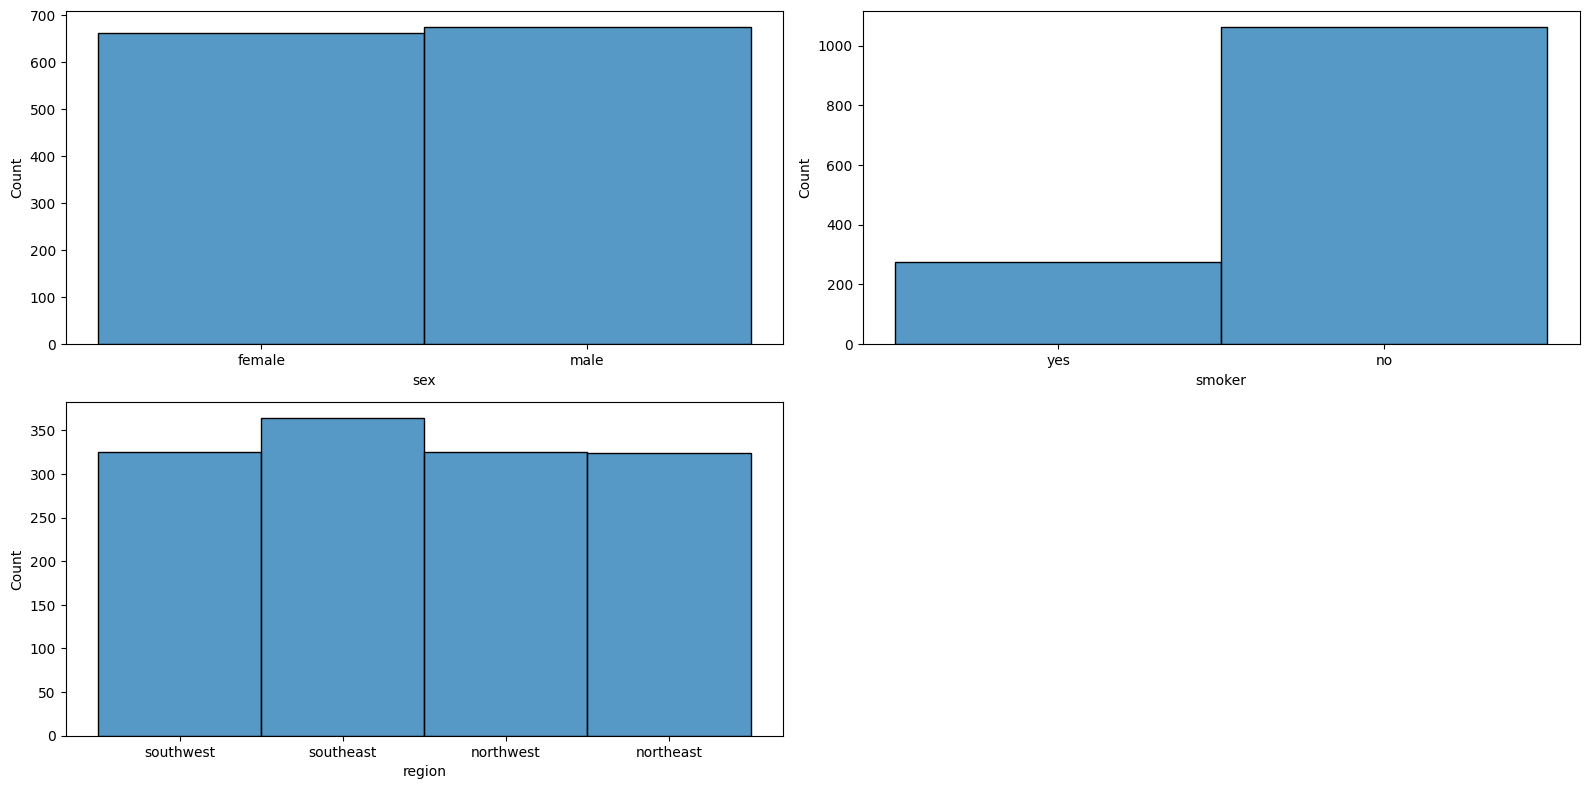

In [13]:
# Ajustes para la visualización de filas y columnas de gráficos
n = len(categorical_column)
n_cols = 2
n_rows = math.ceil(n / n_cols)

fig, axis = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))

# Ajustar que el axis siempre sea 2D
axis = np.array(axis)
if axis.ndim == 1:
    axis = axis.reshape(-1, n_cols)


for index, name_col in enumerate(categorical_column):
    r, c = divmod(index, n_cols)
    sns.histplot(ax = axis[r, c], data=df_copy, x = name_col)
    if len(df_copy[name_col].unique()) > 5:
        axis[r, c].tick_params(axis='x', rotation=45)

# Ocultar subplots vacíos (Esto sirve si hay un número impar a revisar)
for idx in range(n, n_rows * n_cols):
    r, c = divmod(idx, n_cols)
    fig.delaxes(axis[r, c])


plt.tight_layout()
plt.show()

* Hay bastante equidad entre los sexos de los clientes.
* La mayoría son no fumadores y una cuarta proporcion si lo son .
* Esta muy equitativa la región a la que pertenecen pero hay un poco mas en la región sur-este.

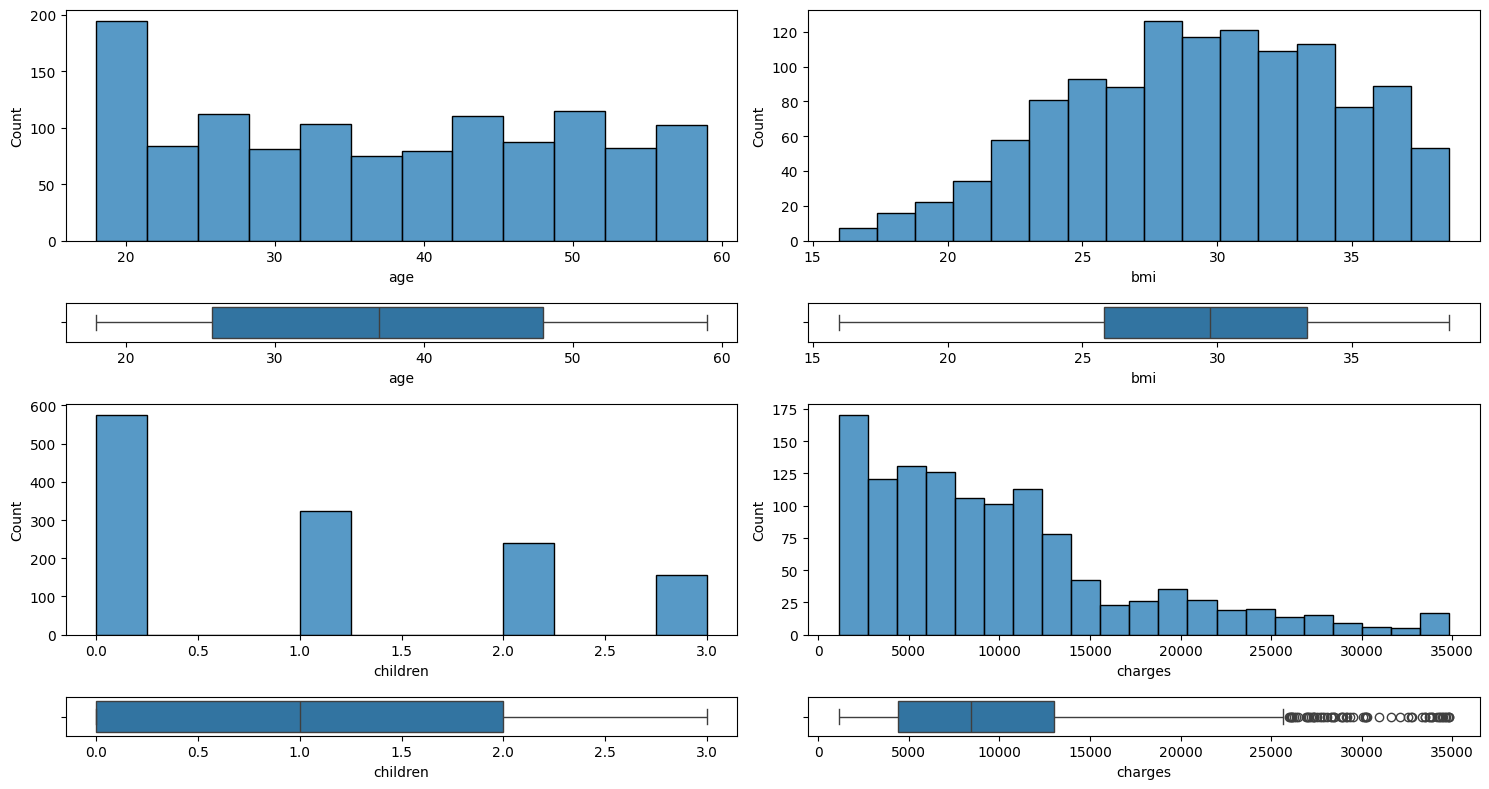

In [14]:
n = len(numerical_column)
n_cols = 2
n_rows = math.ceil(n / n_cols) * 2  # Dos filas por variable para histogramas y boxplots

# Alternar alturas: filas pares grandes para historigraam e impares pequeñas para boxplot
height_ratios = []
for _ in range(n_rows // 2):
    height_ratios.extend([6, 1])
if len(height_ratios) < n_rows:
    height_ratios.append(1)  # Por si hay una fila extra

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 2 * n_rows), gridspec_kw={'height_ratios': height_ratios})

# Asegurar que axis siempre sea 2D
axis = np.array(axis)
if axis.ndim == 1:
    axis = axis.reshape(-1, n_cols)


for idx, col in enumerate(numerical_column):

    #Limitar los datos a los valores por debajo del percentil 90
    datos_filtrados = df_copy[col].copy()
    limite = datos_filtrados.quantile(0.90)
    datos_filtrados = datos_filtrados[datos_filtrados <= limite]

    # Calcular la posición en la cuadrícula
    grid_pos = idx // n_cols
    col_pos = idx % n_cols
    row_hist = grid_pos * 2
    row_box = row_hist + 1

    sns.histplot(ax=axis[row_hist, col_pos], data=datos_filtrados.to_frame(), x=datos_filtrados.name)
    sns.boxplot(ax=axis[row_box, col_pos], data=datos_filtrados.to_frame(), x=datos_filtrados.name)


# Ocultar subplots vacíos (Esto sirve si hay un número impar a revisar)
for idx in range(n, (n_rows // 2) * n_cols):
    grid_pos = idx // n_cols
    col_pos = idx % n_cols
    row_hist = grid_pos * 2
    row_box = row_hist + 1
    fig.delaxes(axis[row_hist, col_pos])
    fig.delaxes(axis[row_box, col_pos])

plt.tight_layout()
plt.show()

* Hay una distribución de `age` en la que  mayoría esta en sus 20's, a partir de ahi el resto de gente se encuentra equitativamente hasta casi los 60
* El `bmi` sigue una distribución normal un poco agrupada hacia la derecha por el grupo de los 30
* El gráfico de `children` sigue una distribución decreciente, la mayoría no tiene hijos y va menguando hasta un maximo de 3 que es poco probable.
* Los `charges`o primas del seguro médico la mayoría se encuentran por los 1000 o 2000, a partir de ahi se va distribuyendo hasta yna caida por el 15000 en donde empiezan a haber menos cantidad de clientes

### 4. Análisis multivariante
**4.1. Codificación de valor categorico - numericos**

In [15]:
def plot_numerical_analisis(column, numerical_column, name = None, column_info = False):
    
    if name is None:
        name = column

    columna_n = f"{column}_n"
    df_plot = df_copy.copy()
    df_plot[columna_n] = pd.factorize(df_plot[column])[0]

    if column_info:
        print(df_plot[[columna_n, column]].drop_duplicates())

    n = len(numerical_column)
    n_cols = 2
    n_rows = math.ceil(n / n_cols) * 2

    fig, axis = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows))

    axis = np.array(axis)
    if axis.ndim == 1:
        axis = axis.reshape(-1, n_cols)

    for idx, col in enumerate(numerical_column):
        limite = df_plot[col].quantile(0.90)
        datos_filtrados = df_plot[df_plot[col] <= limite]

        grid_pos = idx // n_cols
        col_pos = idx % n_cols
        row_hist = grid_pos * 2
        row_box = row_hist + 1

        sns.regplot(ax=axis[row_hist, col_pos], data=datos_filtrados, x=col, y=columna_n).set(ylabel=name)
        sns.heatmap(
            datos_filtrados[[col, columna_n]].corr()
            .rename(columns={columna_n: name}, index={columna_n: name}),
            annot=True, fmt=".2f", ax=axis[row_box, col_pos], cbar=False)
        

    for idx in range(n, (n_rows // 2) * n_cols):
        grid_pos = idx // n_cols
        col_pos = idx % n_cols
        row_hist = grid_pos * 2
        row_box = row_hist + 1
        fig.delaxes(axis[row_hist, col_pos])
        fig.delaxes(axis[row_box, col_pos])

    plt.tight_layout()
    plt.show()

   sex_n     sex
0      0  female
1      1    male


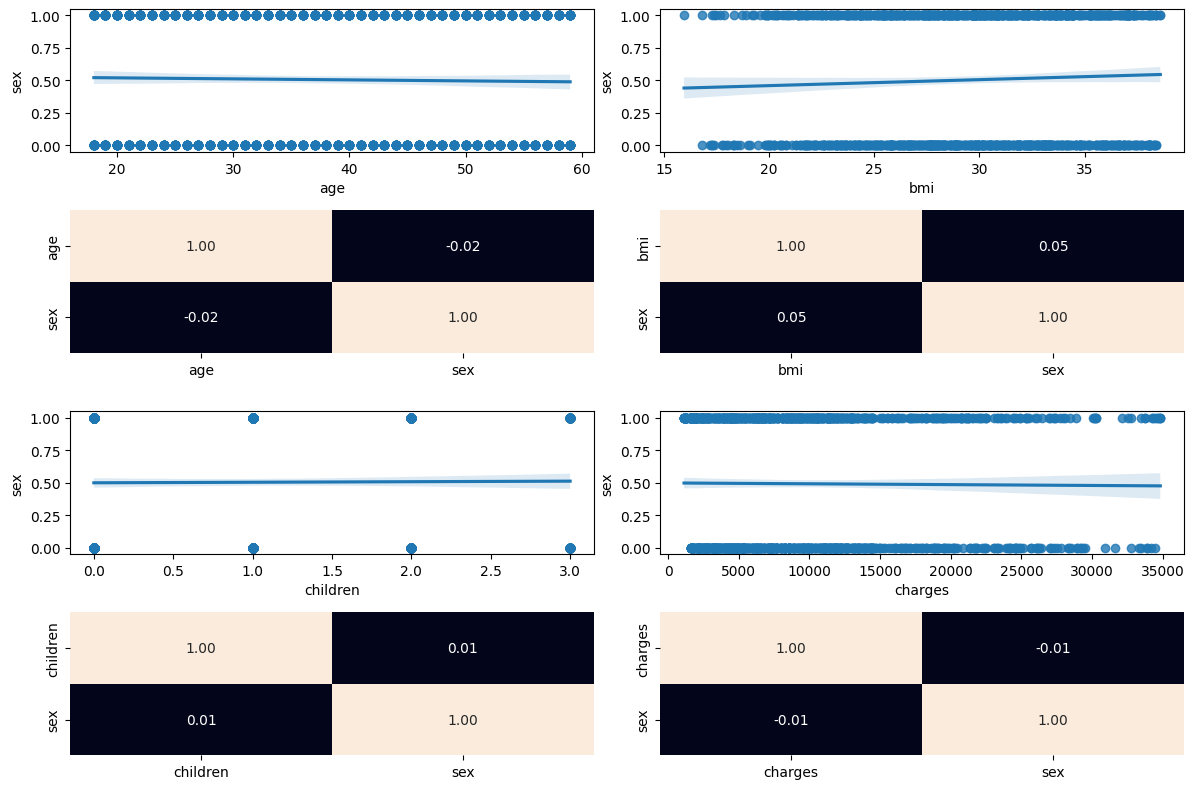

In [16]:
plot_numerical_analisis("sex", numerical_column, column_info=True)

   smoker_n smoker
0         0    yes
1         1     no


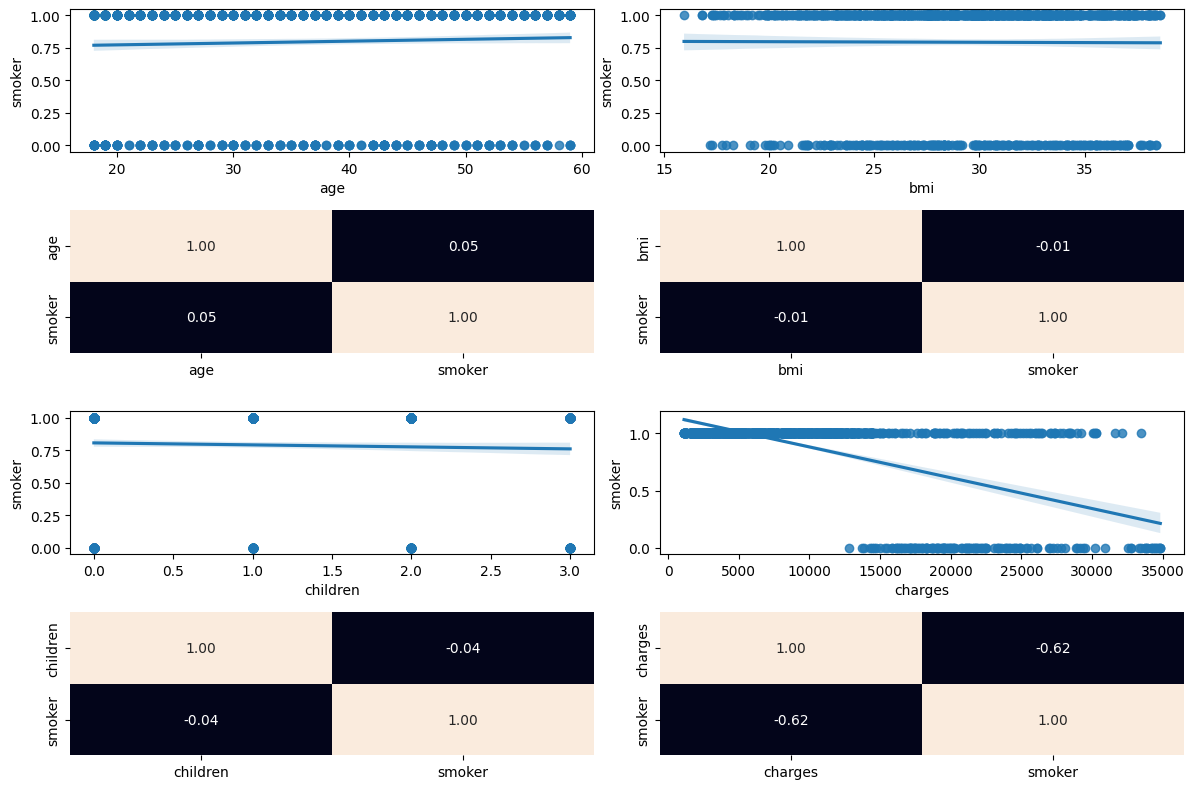

In [17]:
plot_numerical_analisis("smoker", numerical_column, column_info=True)

   region_n     region
0         0  southwest
1         1  southeast
3         2  northwest
8         3  northeast


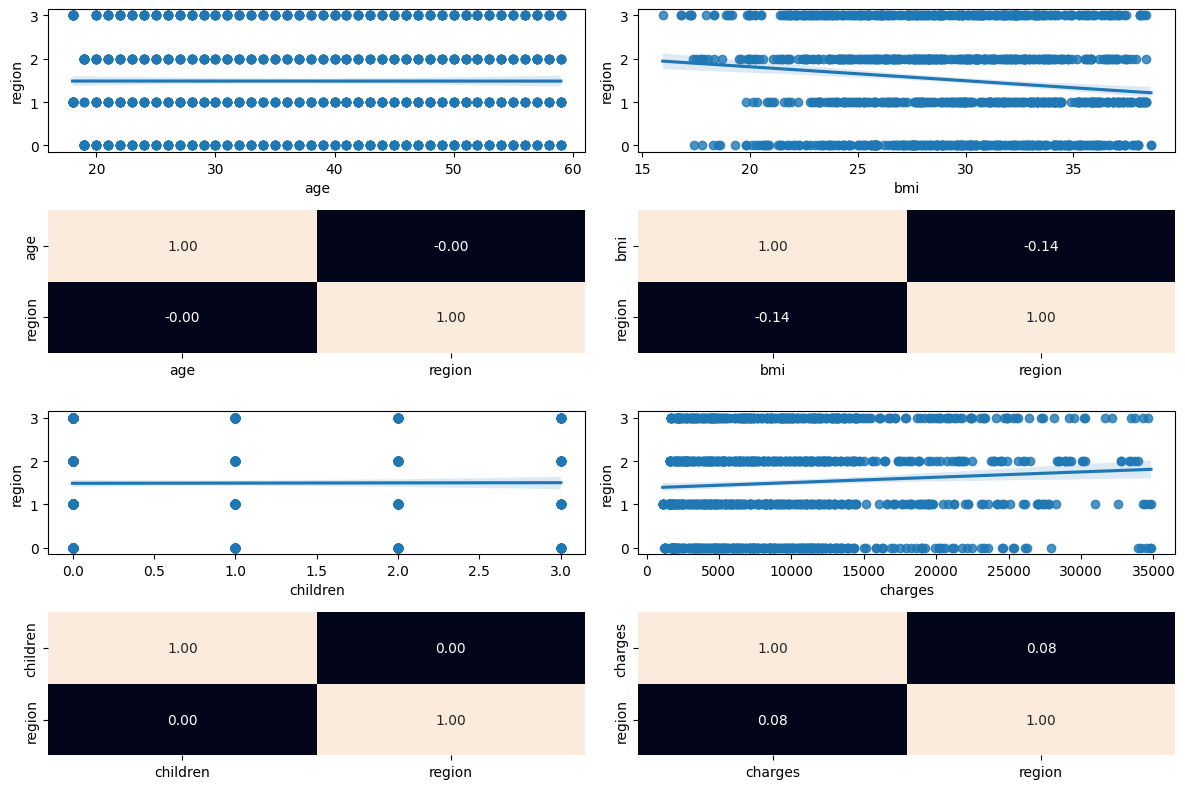

In [18]:
plot_numerical_analisis("region", numerical_column, column_info=True)

* No parece haber una correlación significativa con las columnas categórcias excepto entre `charrges` y `smoker` 

**4.2. Numerico-Numerico Análisis**

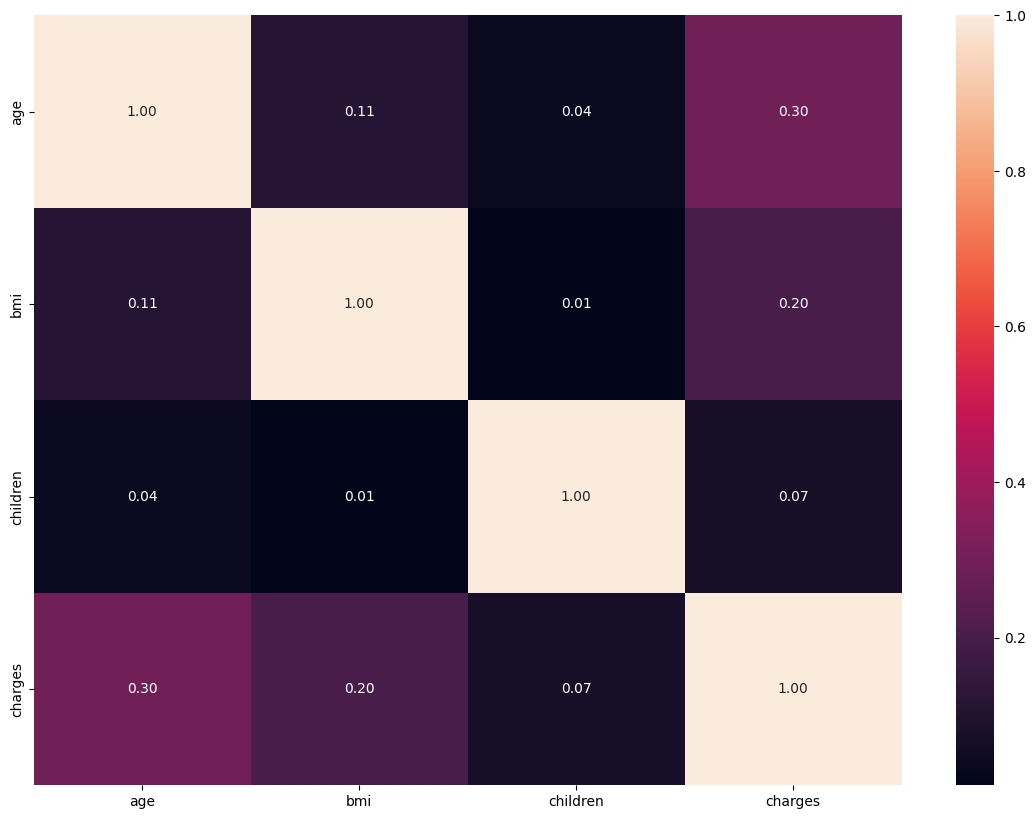

In [19]:
plt.figure(figsize=(14,10))

df_onlyn =  df_copy[numerical_column]

sns.heatmap(df_onlyn.corr().round(2), annot = True, fmt = ".2f")

plt.show()

* Parece haber una ligera influcneica para `charges` con las columnas de `age` (30%) y `bmi` (20%), asi mismo una del (11%) entre estas dos  

**4.3. Categorico-Categorico Análisis**

In [20]:
def plot_categorical_analisis(column1, column2):
    fig, axis = plt.subplots(1, 1, figsize=(15, 5))

    sns.countplot(ax=axis, data=df_copy, x=column1, hue=column2)

    plt.tight_layout()
    plt.show()

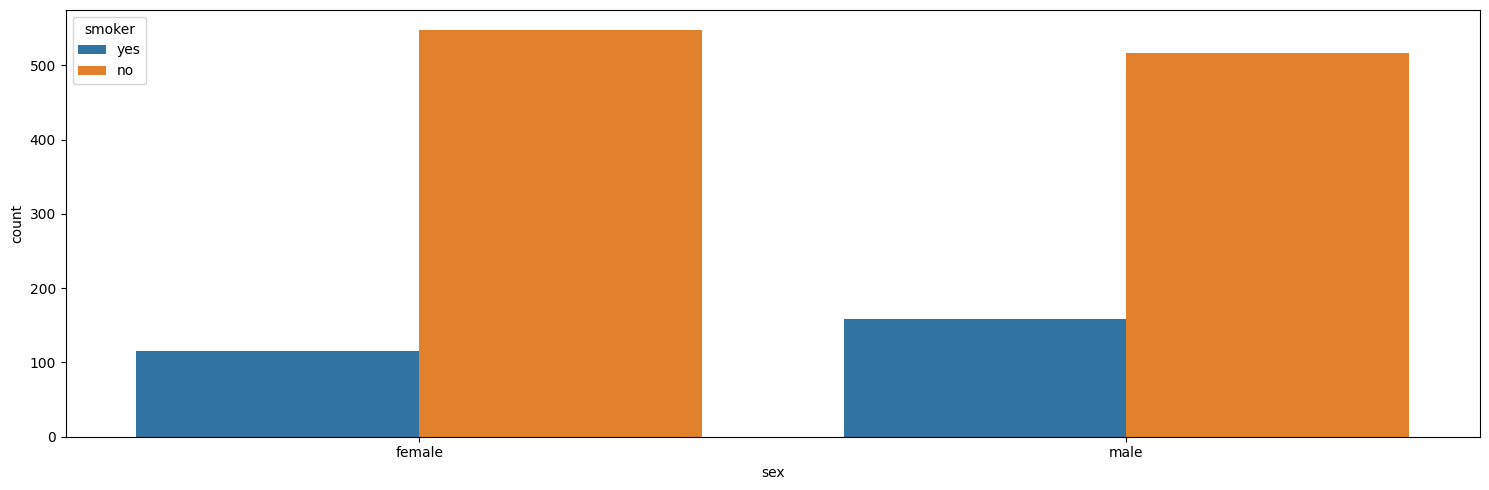

In [21]:
plot_categorical_analisis("sex", "smoker")

* En ambos generos la mayoria no es fumadora, destaca ligeramente que hay mas mujeres no fumadoras, y que hay mas hombres que si fuman

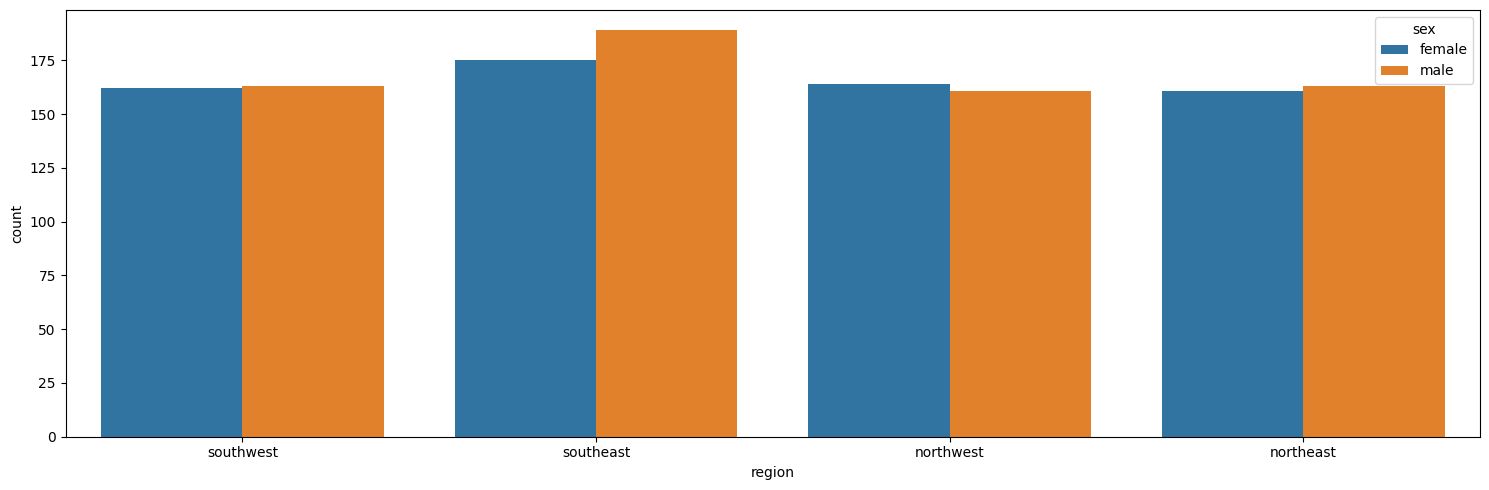

In [23]:
plot_categorical_analisis("region", "sex")

* La mayoría son del sur-este además de hombres

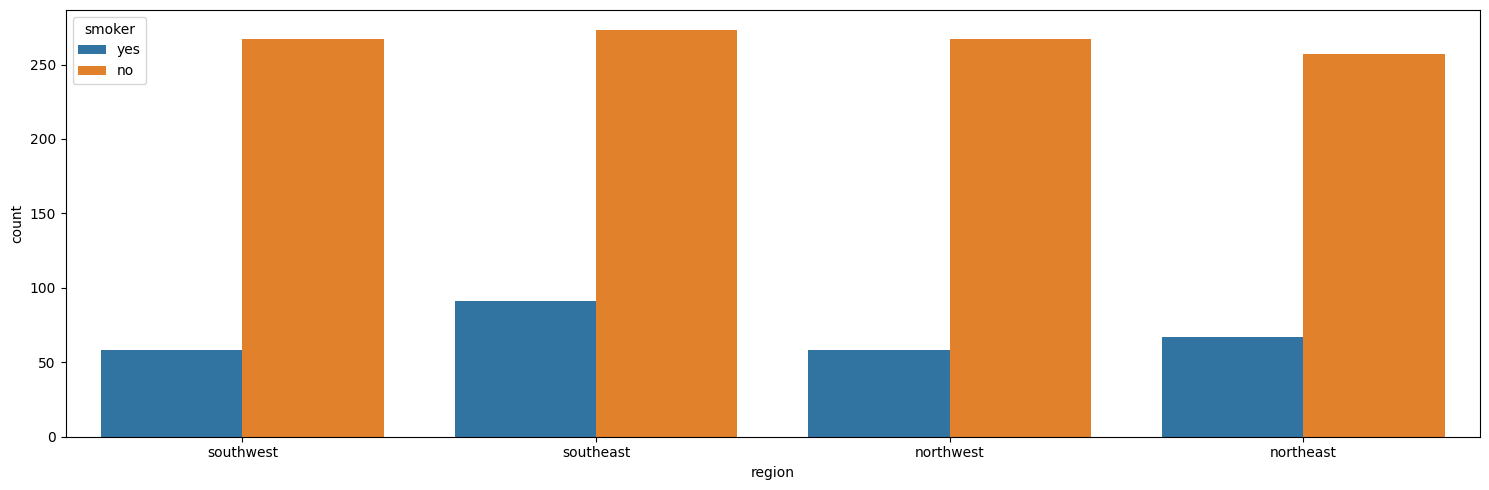

In [24]:
plot_categorical_analisis("region", "smoker")

* Destaca que en cada zona la mayoría son no fumadores y de los que si lo son la mayoría estan en el sur-este seguido del nor-este

**4.4. Combinación de clases predictoras**

In [25]:
def plot_combination_predictoras(categ1, categ2, numerica):
    fig, axis = plt.subplots(1, 1, figsize=(15, 5))

    sns.barplot(ax=axis, data = df_copy, x = categ1, y = numerica, hue = categ2)

    plt.tight_layout()
    plt.show()

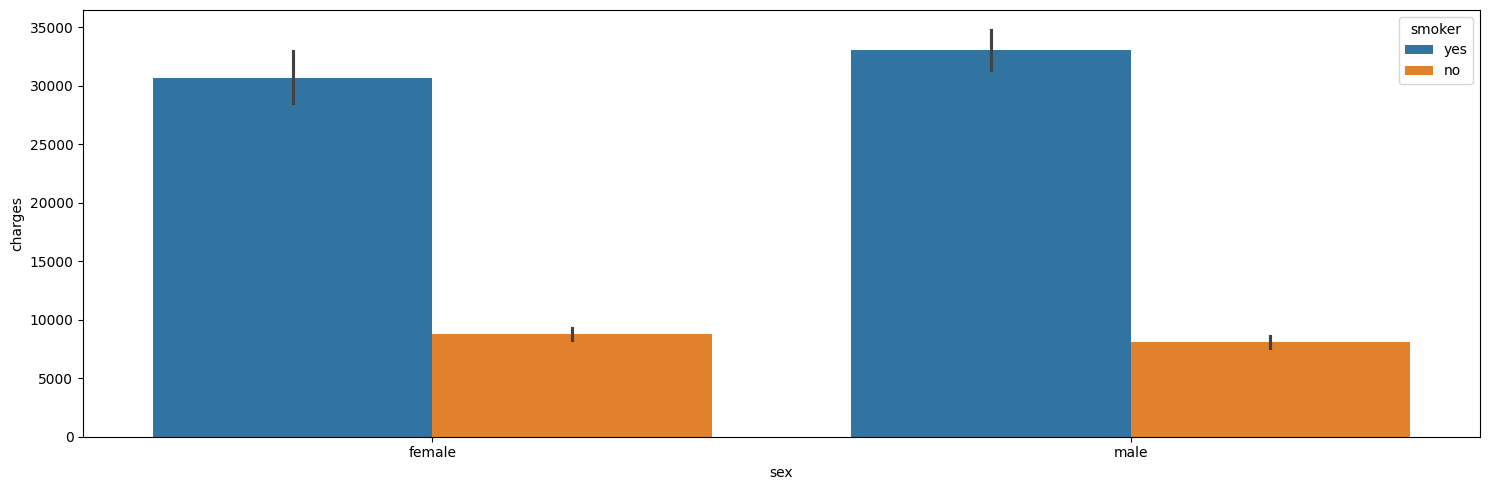

In [27]:
plot_combination_predictoras("sex", "smoker", "charges")

Los fumadores de ambos géneros tienen cargos mas altos que los que no

**4.4. Codificación de valores categóricos y almacenamiento de archivos JSON**

In [8]:
df_num_total = df.copy()
lista_cambios = []

for col in df_num_total.columns:
    if df_num_total[col].dtype == 'object':
        df_num_total[f"{col}_n"] = pd.factorize(df_num_total[col])[0]
        lista_cambios.append(col)
        print(df_num_total[[f"{col}_n", col]].drop_duplicates())

print(f"Las siguientes columnas fueron convertidas a numéricas: {lista_cambios}")

   sex_n     sex
0      0  female
1      1    male
   smoker_n smoker
0         0    yes
1         1     no
   region_n     region
0         0  southwest
1         1  southeast
3         2  northwest
8         3  northeast
Las siguientes columnas fueron convertidas a numéricas: ['sex', 'smoker', 'region']


In [37]:
diccionarios_codificacion = {}

for col in lista_cambios:
    col_n = f"{col}_n"
    # Para cada valor de columna se asocia un valor numerico único
    mapeo = {row[col]: row[col_n] for index, row in df_num_total[[col, col_n]].drop_duplicates().iterrows()}
    diccionarios_codificacion[col] = mapeo

for col, mapeo in diccionarios_codificacion.items():
    print(f"Diccionario para {col}:")
    print(mapeo)
    print()

Diccionario para sex:
{'female': 0, 'male': 1}

Diccionario para smoker:
{'yes': 0, 'no': 1}

Diccionario para region:
{'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3}



In [38]:
for col, mapeo in diccionarios_codificacion.items():

    # Escritura
    with open(f"../data/processed/{col}_n.json", "w") as f:
        json.dump(mapeo, f)

    # Lectura
    with open(f"../data/processed/{col}_n.json", "r") as f:
        mapeo_loaded = json.load(f)
    
    #Convierte los balores categóricos a su valor numerico correspondiente usando el diccionario
    df_num_total[col + "_n"] = df_num_total[col].apply(lambda x: mapeo_loaded[x] if not pd.isna(x) else np.nan)

df_num_total

,age,sex,bmi,children,smoker,region,charges,sex_n,smoker_n,region_n
0,19,female,27.900,0,yes,southwest,16884.92400,0,0,0
1,18,male,33.770,1,no,southeast,1725.55230,1,1,1
2,28,male,33.000,3,no,southeast,4449.46200,1,1,1
3,33,male,22.705,0,no,northwest,21984.47061,1,1,2
4,32,male,28.880,0,no,northwest,3866.85520,1,1,2
...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1,1,2
1334,18,female,31.920,0,no,northeast,2205.98080,0,1,3
1335,18,female,36.850,0,no,southeast,1629.83350,0,1,1
1336,21,female,25.800,0,no,southwest,2007.94500,0,1,0


**4.5. Análisis final de correlaciones**

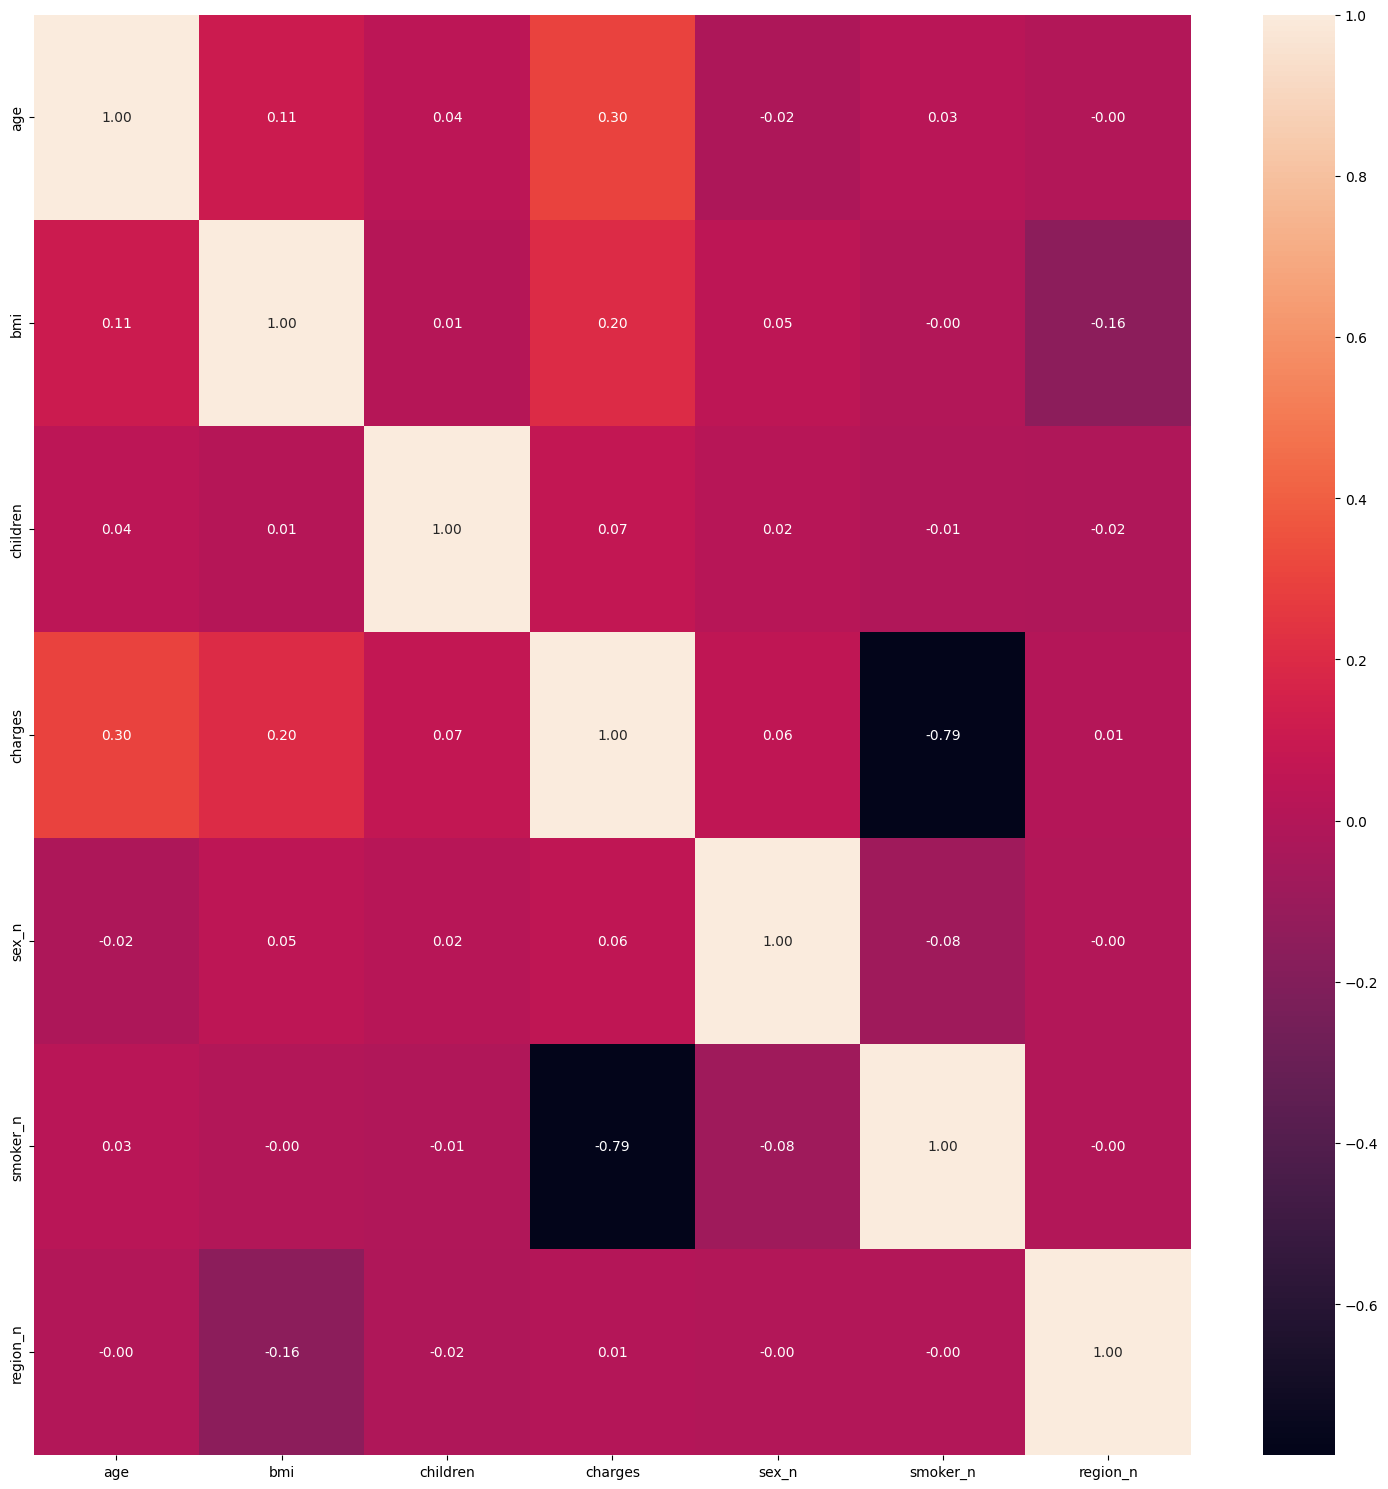

In [9]:
fig, axis = plt.subplots(figsize = (15, 15))

num_list = [col for col in df_num_total.columns if df_num_total[col].dtype == "int64" or df_num_total[col].dtype == "float64"]
df_enc = df_num_total[[col for col in df_num_total.columns if col in num_list]]
sns.heatmap(df_num_total[num_list].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

Conclusiones: 
* hay una relacción significativa entre fumadores y las primas.
* Relación ligera entre las primas con la edad y el bmi
* Una ligera influencia del 16% entre bmi y la región

### 5.5. Ingeniería de características
**5.1. Análisis de outliers**

In [40]:
df_enc.corr().describe()

,age,bmi,children,charges,sex_n,smoker_n,region_n
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.207541,0.172204,0.159450,0.120228,0.145600,0.021140,0.117597
std,0.365765,0.380976,0.371764,0.525241,0.379384,0.520119,0.393355
min,-0.020856,-0.157566,-0.016569,-0.787251,-0.076185,-0.787251,-0.157566
25%,0.011446,0.004504,0.002543,0.031750,-0.012722,-0.041929,-0.010579
50%,0.042469,0.046371,0.017163,0.067998,0.017163,-0.003750,-0.002181
75%,0.204140,0.153806,0.055234,0.248675,0.051832,0.011419,0.002040
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Las siguientes columnas continuas fueron identificadas: ['age', 'bmi', 'children', 'charges', 'sex_n', 'smoker_n', 'region_n']


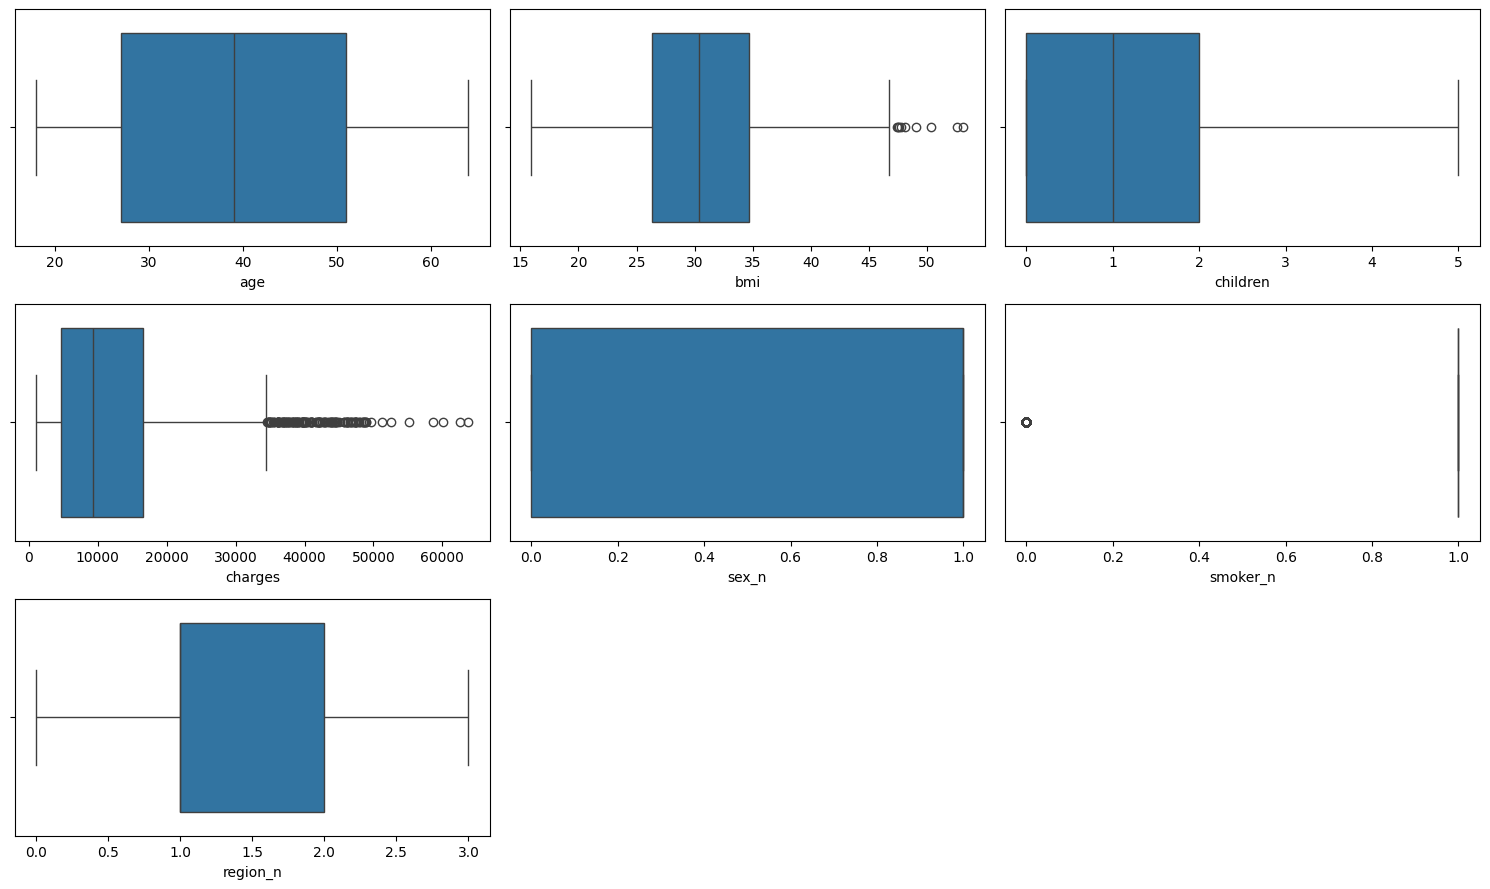

In [13]:
lista_col = list(df_enc.select_dtypes(('float64', 'int64'))) 
print(f"Las siguientes columnas continuas fueron identificadas: {lista_col}")
n = len(lista_col)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axis = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

axis = np.array(axis)
if axis.ndim == 1:
    axis = axis.reshape(-1, n_cols)

for idx, col in enumerate(df_enc[lista_col]):
    row = idx // n_cols
    col_pos = idx % n_cols
    sns.boxplot(ax=axis[row, col_pos], data=df_enc, x=col)

# Oculta subplots vacíos
for idx in range(len(lista_col), n_rows * n_cols):
    row = idx // n_cols
    col_pos = idx % n_cols
    fig.delaxes(axis[row, col_pos])

plt.tight_layout()
plt.show()

* Los datos mas importantes a analizar son los float, en los que destacan `charges` y `bmi` por tener outliers.

In [10]:
# Crear una copia para eliminar outliers
df_enc_no = df_enc.copy()

In [11]:
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'../data/interim/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [14]:
# outliers con y sin negativos
f_outliers_with_neg = []
f_outliers_no_neg = []

for each in lista_col:
    if df_enc[each].min() < 0:
        f_outliers_with_neg.append(each)
    f_outliers_no_neg.append(each)

for feature in f_outliers_with_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature)

for feature in f_outliers_no_neg:
    df_enc_no[feature] = remove_outliers(df_enc_no[feature], feature, allow_neg=False)

In [52]:
df_enc.describe()

,age,bmi,children,charges,sex_n,smoker_n,region_n
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,0.505232,0.795217,1.484305
std,14.049960,6.098187,1.205493,12110.011237,0.500160,0.403694,1.104885
min,18.000000,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000,1.000000,1.000000
50%,39.000000,30.400000,1.000000,9382.033000,1.000000,1.000000,1.000000
75%,51.000000,34.693750,2.000000,16639.912515,1.000000,1.000000,2.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,3.000000


In [51]:
df_enc_no.describe()

,age,bmi,children,charges,sex_n,smoker_n,region_n
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.0,1338.000000
mean,39.207025,30.650034,1.094918,12479.369251,0.505232,1.0,1.484305
std,14.049960,6.056926,1.205493,10158.056096,0.500160,0.0,1.104885
min,18.000000,15.960000,0.000000,1121.873900,0.000000,1.0,0.000000
25%,27.000000,26.296250,0.000000,4740.287150,0.000000,1.0,1.000000
50%,39.000000,30.400000,1.000000,9382.033000,1.000000,1.0,1.000000
75%,51.000000,34.693750,2.000000,16639.912515,1.000000,1.0,2.000000
max,64.000000,47.290000,5.000000,34489.350562,1.000000,1.0,3.000000


**5.2. Dividir el train/test de marcos de datos**

In [15]:
objetivo = 'charges'
def split(target, df, reference: str, test_size=0.2, random_state=123):
    X = df.drop(columns=target)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_train.to_csv(f'../data/processed/X_train_{reference}.csv', index=False)
    X_test.to_csv(f'../data/processed/X_test_{reference}.csv', index=False)
    y_train.to_csv('../data/processed/y_train.csv', index=False)
    y_test.to_csv('../data/processed/y_test.csv', index=False)
    
    return X_train, X_test, y_train, y_test

In [16]:
# Separar el DataFrame original 
X_train_con_outliers, X_test_con_outliers, y_train, y_test = split(objetivo, df_enc, 'with_outliers')
X_train_sin_outliers, X_test_sin_outliers, _, _ = split(objetivo, df_enc_no, 'without_outliers')

### 6. Procesamiento de Datos
**6.1. Normalización**

In [17]:
#Retiramos el target de la lista de columnas de estudio
# Esto es necesario para que no se incluya en el entrenamiento y pruebas posteriores
column_list = list(df_enc.columns.drop(objetivo))

In [18]:
### NORMALIZAMOS EL DATAFRAME CON OUTLIERS Y LO GUARDAMOS
normalizador_con_outliers = StandardScaler()
normalizador_con_outliers.fit(X_train_con_outliers) #Recuerda que es el entrenamiento

X_train_con_outliers_norm = normalizador_con_outliers.transform(X_train_con_outliers) #Se aplica la normalización
X_train_con_outliers_norm = pd.DataFrame(X_train_con_outliers_norm, index = X_train_con_outliers.index, columns = column_list) #Se crea un nuevo DataFrame con los datos normalizados

X_test_con_outliers_norm = normalizador_con_outliers.transform(X_test_con_outliers) #Lo mismo para el test
X_test_con_outliers_norm = pd.DataFrame(X_test_con_outliers_norm, index = X_test_con_outliers.index, columns = column_list)


### NORMALIZAMOS EL DATAFRAME SIN OUTLIERS Y LO GUARDAMOS
normalizador_sin_outliers = StandardScaler()
normalizador_sin_outliers.fit(X_train_sin_outliers)

X_train_sin_outliers_norm = normalizador_sin_outliers.transform(X_train_sin_outliers) #Se repite el proceso pero sin outliers
X_train_sin_outliers_norm = pd.DataFrame(X_train_sin_outliers_norm, index = X_train_sin_outliers.index, columns = column_list)

X_test_sin_outliers_norm = normalizador_sin_outliers.transform(X_test_sin_outliers)
X_test_sin_outliers_norm = pd.DataFrame(X_test_sin_outliers_norm, index = X_test_sin_outliers.index, columns = column_list)

X_train_con_outliers_norm.head()

,age,bmi,children,sex_n,smoker_n,region_n
67,0.062072,-0.719610,-0.067366,0.988847,0.5,0.460389
736,-0.150575,1.286979,-0.886479,-1.011279,-2.0,-0.456960
310,0.770896,-0.672250,-0.886479,0.988847,0.5,-1.374308
963,0.487366,-0.972199,1.570860,0.988847,0.5,1.377737
680,-1.284694,-2.201079,-0.067366,-1.011279,0.5,-1.374308


**6.2. Escalado Mínimo-Máximo**

In [19]:
### NORMALIZAMOS EL DATAFRAME CON OUTLIERS Y LO GUARDAMOS
scaler_con_outliers = MinMaxScaler()
scaler_con_outliers.fit(X_train_con_outliers)

X_train_con_outliers_scal = scaler_con_outliers.transform(X_train_con_outliers)
X_train_con_outliers_scal = pd.DataFrame(X_train_con_outliers_scal, index = X_train_con_outliers.index, columns = column_list)

X_test_con_outliers_scal = scaler_con_outliers.transform(X_test_con_outliers)
X_test_con_outliers_scal = pd.DataFrame(X_test_con_outliers_scal, index = X_test_con_outliers.index, columns = column_list)


### ESCALAMOS EL DATAFRAME SIN OUTLIERS Y LO GUARDAMOS
scaler_sin_outliers = MinMaxScaler()
scaler_sin_outliers.fit(X_train_sin_outliers)

X_train_sin_outliers_scal = scaler_sin_outliers.transform(X_train_sin_outliers)
X_train_sin_outliers_scal = pd.DataFrame(X_train_sin_outliers_scal, index = X_train_sin_outliers.index, columns = column_list)

X_test_sin_outliers_scal = scaler_sin_outliers.transform(X_test_sin_outliers)
X_test_sin_outliers_scal = pd.DataFrame(X_test_sin_outliers_scal, index = X_test_sin_outliers.index, columns = column_list)

X_train_con_outliers_scal.head()

,age,bmi,children,sex_n,smoker_n,region_n
67,0.478261,0.278585,0.2,1.0,1.0,0.666667
736,0.413043,0.603444,0.0,0.0,0.0,0.333333
310,0.695652,0.286252,0.0,1.0,1.0,0.000000
963,0.608696,0.237692,0.6,1.0,1.0,1.000000
680,0.065217,0.038741,0.2,0.0,1.0,0.000000


**6.3. Guardado en archivos xlsx**

In [20]:
lista = ["X_train_con_outliers", "X_train_sin_outliers", "X_train_con_outliers_norm", "X_train_sin_outliers_norm", "X_train_con_outliers_scal", "X_train_sin_outliers_scal",
         "X_test_con_outliers", "X_test_sin_outliers", "X_test_con_outliers_norm", "X_test_sin_outliers_norm", "X_test_con_outliers_scal", "X_test_sin_outliers_scal",
         "y_train", "y_test"]
for var in lista:
    globals()[var].to_excel(f"../data/processed/{var}.xlsx", index = False)

In [21]:
with open("../models/normalizador_con_outliers.pkl", "wb") as file:
  pickle.dump(normalizador_con_outliers, file)

with open("../models/normalizador_sin_outliers.pkl", "wb") as file:
  pickle.dump(normalizador_sin_outliers, file)

with open("../models/scaler_con_outliers.pkl", "wb") as file:
  pickle.dump(scaler_con_outliers, file)

with open("../models/scaler_sin_outliers.pkl", "wb") as file:
  pickle.dump(scaler_sin_outliers, file)

### 7. Machine Learning
**7.1. Decisión de DataSet y Regresión lineal**

In [22]:
train, test = [], []

for var in lista:
    df = pd.read_excel(f"../data/processed/{var}.xlsx")
    if "train" in var:
        train.append((var, df))
    elif "test" in var:
        test.append((var, df))

In [24]:
results_mse = []
results_r2 = []
models = []
datasets = [
    ("X_train_con_outliers", X_train_con_outliers),
    ("X_train_sin_outliers", X_train_sin_outliers),
    ("X_train_con_outliers_norm", X_train_con_outliers_norm),
    ("X_train_sin_outliers_norm", X_train_sin_outliers_norm),
    ("X_train_con_outliers_scal", X_train_con_outliers_scal),
    ("X_train_sin_outliers_scal", X_train_sin_outliers_scal),
]

for name, dataset in datasets:
    model = LinearRegression()
    model.fit(dataset, y_train)
    y_pred = model.predict(dataset)
    
    mse = mean_squared_error(y_train, y_pred) #Error cuadrático medio
    r2 = r2_score(y_train, y_pred) #Coeficiente de determinación

    results_mse.append(mse)
    results_r2.append(r2)
    models.append((name, model))
  
#Elegir el mejor según R (más alto es mejor)
best_index = results_r2.index(max(results_r2))

print("Resultados MSE:", results_mse)
print("Resultados R²:", results_r2)
print("Mejor R²:", max(results_r2))
print("Mejor dataset:", datasets[best_index][0])

best_dataset = datasets[best_index][1]



Resultados MSE: [38043592.83839541, 125716275.60226296, 38043592.83839541, 125716275.60226296, 38043592.83839541, 125716275.60226296]
Resultados R²: [0.7374832271482907, 0.1325048844299923, 0.7374832271482907, 0.1325048844299923, 0.7374832271482907, 0.1325048844299923]
Mejor R²: 0.7374832271482907
Mejor dataset: X_train_con_outliers


El mejor dataset para trabajar es el X_train_con_outliers

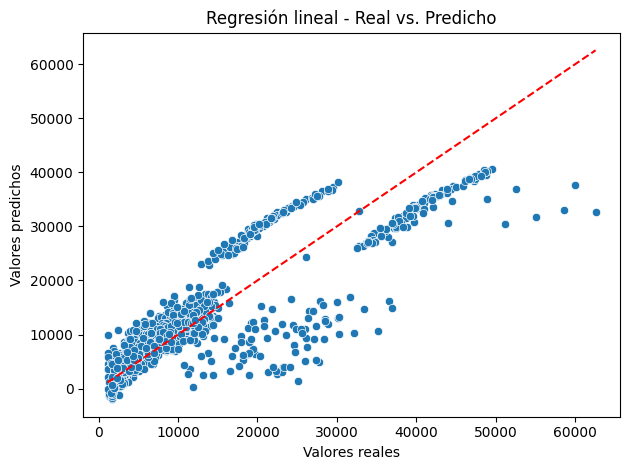

In [ ]:
model = models[best_index][1]
X = best_dataset
y_pred = model.predict(X)

sns.scatterplot(x=y_train, y=y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.title("Regresión lineal - Real vs. Predicho")
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--') 
plt.tight_layout()
plt.show()

A pesar de que los valores bajos se mantienen por la linea a medida que crecen se van desviando

**7.2. Modelo Lineal Regularizado**

In [40]:
lasso_model = Lasso(alpha = 0.1, max_iter = 300)

lasso_model.fit(X_train_con_outliers, y_train)

y_pred_lasso = lasso_model.predict(X_test_con_outliers)


In [41]:
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("R2:", r2_score(y_test, y_pred_lasso))

MSE: 30601043.888524704
R2: 0.7998565424468016


In [43]:
ridge_model = Ridge(alpha = 0.1, max_iter = 300)

ridge_model.fit(X_train_con_outliers, y_train)

y_pred_ridge = ridge_model.predict(X_test_con_outliers)

In [44]:
print("MSE:", mean_squared_error(y_test, y_pred_ridge))
print("R2:", r2_score(y_test, y_pred_ridge))

MSE: 30608357.150750816
R2: 0.7998087106933078


In [50]:
hiperparam = {
    'alpha': [0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

grid = GridSearchCV(ElasticNet(), hiperparam, cv=5)
grid.fit(X_train_con_outliers, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor score (R² en validación):", grid.best_score_)

y_pred_elastic = grid.predict(X_test_con_outliers)

Mejores parámetros: {'alpha': 10, 'l1_ratio': 1}
Mejor score (R² en validación): 0.7334164467192699


In [51]:
print("MSE:", mean_squared_error(y_test, y_pred_elastic))
print("R2:", r2_score(y_test, y_pred_elastic))

MSE: 30642728.27841801
R2: 0.7995839093317473


* Los resultados del error cuadratico medio son bastante similares entre los dos, al igual que el coeficiente de determinación.
* Según los hiperparametros, el l1_ratio fue hacia 1 es decir que se comportó como Lasso

Conclusión:
* Aunque se parezcan en ajustes el mejor resultado es el de Lasso